In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='roberta-large'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'g':[]}

In [4]:
gamma = [2,4,8,16]
lr = 1.0e-4

for g in gamma:
    print(f'Grid search {model_checkpoint}, learning rate {lr}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=32)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.device = model.device
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=0.0,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalfocalloss=True,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['lr'].append(lr)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search roberta-large, lr: 1e-05 ,focal loss, gamma: 2


Map:   0%|          | 0/1796 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 10: Train Loss:	0.1745	Val Loss:	0.5708	Accuracy:	0.8206	F1:	0.7431
2 / 10: Train Loss:	0.1261	Val Loss:	0.5201	Accuracy:	0.8074	F1:	0.7735
3 / 10: Train Loss:	0.0889	Val Loss:	0.4380	Accuracy:	0.8031	F1:	0.7789
4 / 10: Train Loss:	0.0651	Val Loss:	0.4202	Accuracy:	0.8775	F1:	0.8426
5 / 10: Train Loss:	0.0459	Val Loss:	0.5315	Accuracy:	0.7199	F1:	0.7037
6 / 10: Train Loss:	0.0391	Val Loss:	0.3386	Accuracy:	0.8665	F1:	0.8357
7 / 10: Train Loss:	0.0231	Val Loss:	0.3169	Accuracy:	0.8753	F1:	0.8255
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.83      0.66      0.73       119
      struct       0.89      0.95      0.92       338

    accuracy                           0.88       457
   macro avg       0.86      0.80      0.83       457
weighted avg       0.87      0.88      0.87       457

test results:
              precision    recall  f1-score   support

       bknow

In [6]:
Engine.plot_grid_search(df=results,
                        title=f'Focal loss, lr: {lr}, {model_checkpoint}',
                        column='g',
                        sci_format=False)

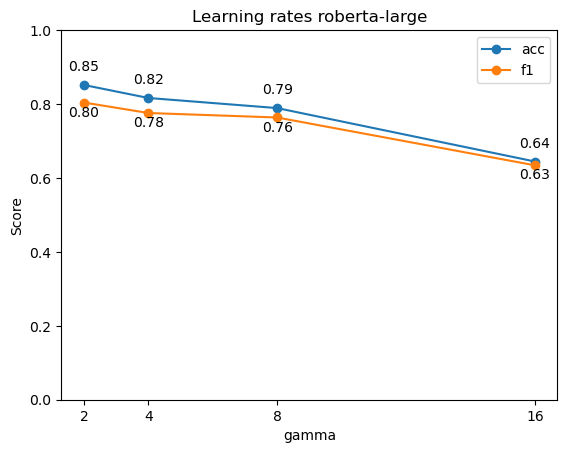

In [10]:
%reset -f